In [43]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.image_classification.models.extraction import ExtractionFeatureExtractor
from torchlake.common.utils.image import load_image
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.object_detection.models.yolov1 import YOLOV1, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from pathlib import Path

# setting

In [45]:
artifact_path = Path('../../artifacts/yolov1/extraction')
artifact_path.mkdir(exist_ok=True)

In [46]:
data_path = Path("../../data/VOCdevkit")

In [47]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [48]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [49]:
BATCH_SIZE = 16

In [50]:
IMAGE_SIZE = 448

In [51]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [52]:
# train_dataset = VOCDetectionFromCSV(
#     data_path,
#     data_path.joinpath("voc_trainval.csv"),
#     transform=transform,
# )

In [53]:
train_dataset = VOCDetectionFromLMDB(
    "../../data/VOCdevkit/voc",
    transform=transform,
)

In [54]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [55]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [56]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([16, 3, 448, 448]) 16


# model

In [57]:
weight_path = Path("../../artifacts/extraction/extraction.pth")
backbone = ExtractionFeatureExtractor("block", weight_path, trainable=False)
backbone.fix_target_layers(["2_1"])

In [58]:
model = YOLOV1(backbone, CONTEXT, dropout_prob=0.5).to(CONTEXT.device)

In [59]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
YOLOV1                                                  --
├─ExtractionFeatureExtractor: 1-1                       --
│    └─Extraction: 2-1                                  --
│    │    └─Sequential: 3-1                             (120,512)
│    │    └─Sequential: 3-2                             (22,291,712)
│    │    └─Sequential: 3-3                             --
├─Sequential: 1-2                                       --
│    └─Conv2dNormActivation: 2-2                        --
│    │    └─Conv2d: 3-4                                 9,437,184
│    │    └─BatchNorm2d: 3-5                            2,048
│    │    └─LeakyReLU: 3-6                              --
│    └─Conv2dNormActivation: 2-3                        --
│    │    └─Conv2d: 3-7                                 9,437,184
│    │    └─BatchNorm2d: 3-8                            2,048
│    │    └─LeakyReLU: 3-9                              --
│    └─Conv2dN

# train

In [18]:
EPOCH = 10

In [19]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [21]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [22]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 1034/1034 [02:33<00:00,  6.73it/s]


epoch 1 : 3.216511643140413 (0%)


100%|██████████| 1034/1034 [02:30<00:00,  6.89it/s]


epoch 2 : 2.5778221966450174 (-20%)


100%|██████████| 1034/1034 [02:28<00:00,  6.95it/s]


epoch 3 : 2.291209611602171 (-11%)


100%|██████████| 1034/1034 [02:27<00:00,  7.00it/s]


epoch 4 : 2.1853365975376255 (-5%)


100%|██████████| 1034/1034 [02:29<00:00,  6.94it/s]


epoch 5 : 2.0328392567440896 (-7%)


100%|██████████| 1034/1034 [02:30<00:00,  6.85it/s]


epoch 6 : 1.896174511088624 (-7%)


100%|██████████| 1034/1034 [02:29<00:00,  6.93it/s]


epoch 7 : 2.0189103552174523 (6%)


100%|██████████| 1034/1034 [02:28<00:00,  6.98it/s]


epoch 8 : 1.7073769560750265 (-15%)


100%|██████████| 1034/1034 [02:30<00:00,  6.85it/s]


epoch 9 : 1.6002095681786306 (-6%)


100%|██████████| 1034/1034 [02:32<00:00,  6.80it/s]

epoch 10 : 1.5467558727388917 (-3%)


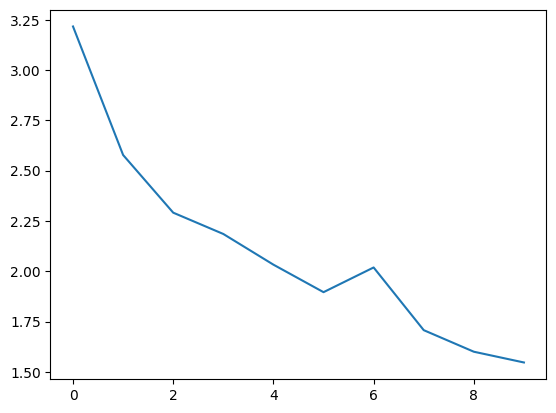

In [23]:
plt.plot(training_loss)

In [60]:
model_path = artifact_path / f'yolov1.{backbone.network_name}.10.pth'

In [33]:
torch.save(model.state_dict(), model_path)

In [34]:
get_file_size(model_path)

'309.03MiB'

In [61]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# inference

In [63]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [64]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [65]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [66]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [67]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [68]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [69]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [70]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [71]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/310 [00:00<?, ?it/s]


In [72]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

boat: 0.26
aeroplane: 0.36
cat: 0.47
person: 0.24
bus: 0.64
dog: 0.20
dog: 0.10
sheep: 0.14
sheep: 0.16
person: 0.10
person: 0.11
person: 0.12
sheep: 0.22
sheep: 0.11
sheep: 0.12
sheep: 0.12
sheep: 0.12
diningtable: 0.16
bottle: 0.11
bottle: 0.50
car: 0.20
bottle: 0.21
person: 0.18


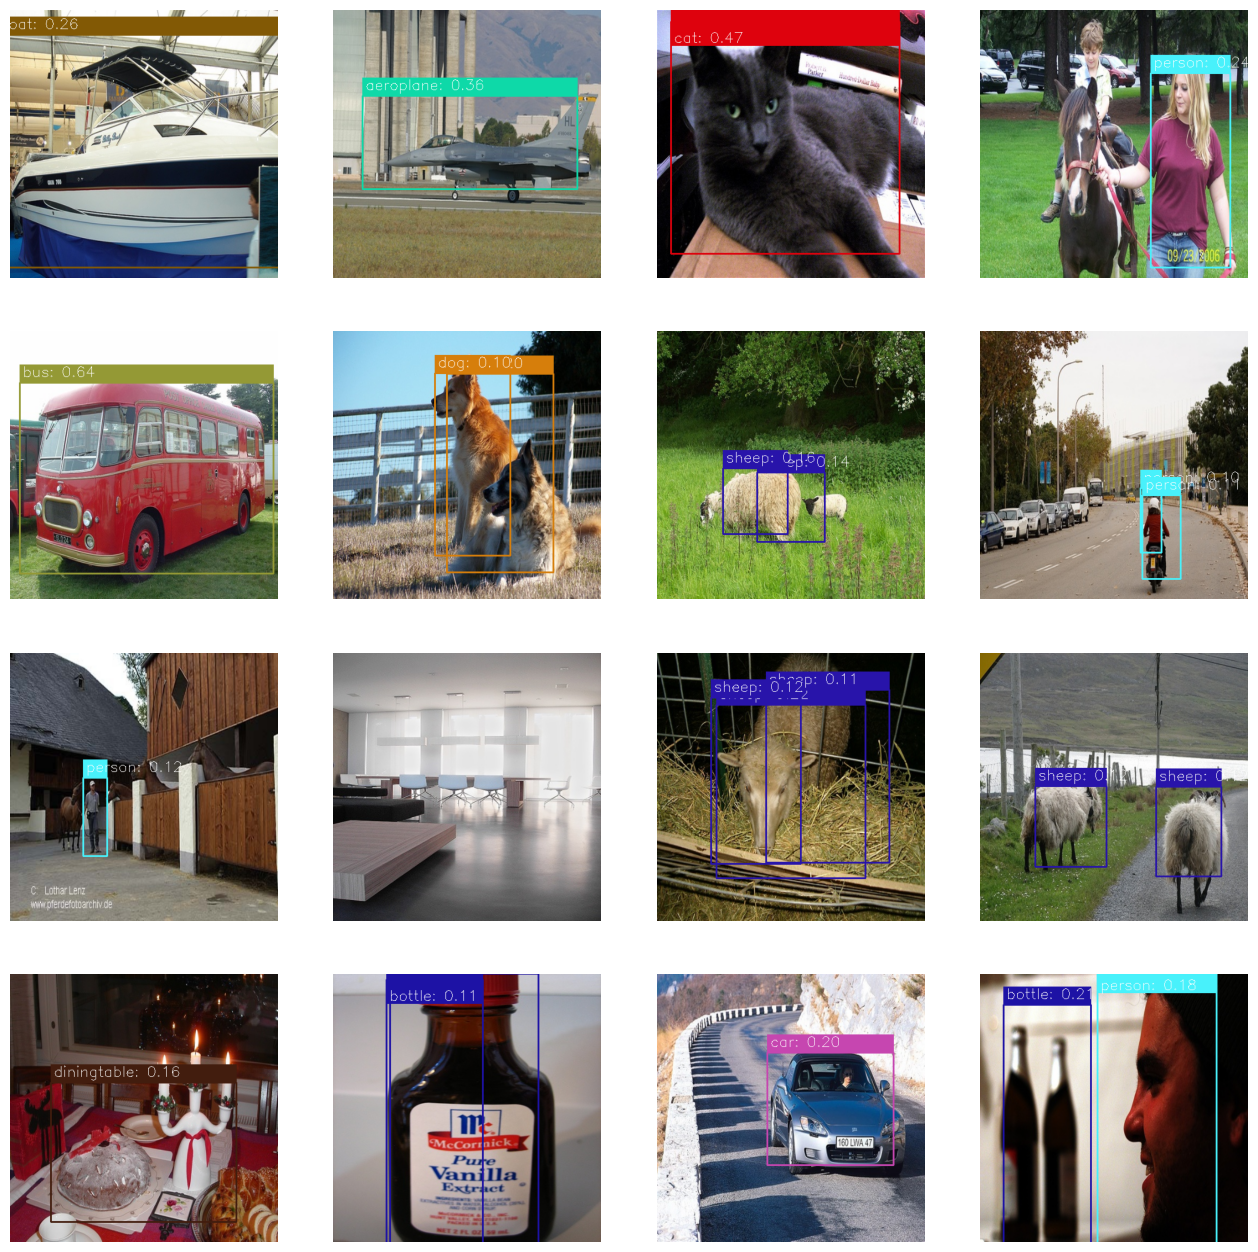

In [73]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [74]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.22
person: 0.27
person: 0.12
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 3
person: 0.11
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.55
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.25
person: 0.23
person: 0.24
person: 0.22
person: 0.25
person: 0.24
person: 0.22
person: 0.20
person: 0.23
person: 0.21
person: 0.26
person: 0.25
person: 0.22
person: 0.23
person: 0.27
person: 0.30
person: 0.29
person: 0.29
person: 0.10
person: 0.15
person: 0.15
person: 0.19
person: 0.18
person: 0.23
person: 0.24
person: 0.16
person: 0.11
person: 0.11
person: 0.12
person: 0.11
person: 0.13
person: 0.10
person: 0.12
person: 0.12
person: 0.11
person: 0.22
person: 0.21
person: 0.20
person: 0.18
person: 0.20
person: 0.24
person: 0.26
person: 0.27
person: 0.27
person: 0.26
person: 0.24
person: 0.27
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.21
person: 0.21
person: 0.20
person: 0.21
person: 0.20
person: 0.19
person: 0.19
person: 0.21
person: 0.22
person: 0.22
person: 0.25
person: 0.28
person: 0.27
person: 0.31
person: 0.30
person: 0.30
person: 0.28
person: 0.29
person: 0.30
person: 0.29
person: 0.27
person: 0.28
person: 0.28
person: 0.29

# evaluation

In [35]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [36]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [37]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [38]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [39]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [40]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [41]:
evaluator = Evaluator(CONTEXT)

In [ ]:
# block 2_1
# dropout prob : 0.5
# trainable: true
# 0.1866

# block 2_1
# dropout prob : 0
# trainable: true
# 0.128

# block 2_1
# dropout prob : 0.5
# trainable: false
# 0.34

# block 3_1
# dropout prob : 0.5
# trainable: false
# 0.306


In [31]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 310/310 [01:38<00:00,  3.16it/s]

       aeroplane   bicycle      bird      boat    bottle       bus      car  \
AP@0.5  0.434565  0.418949  0.399093  0.327905  0.301037  0.310354  0.33217   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.333213  0.316897  0.311411  ...  0.324982  0.331248  0.331361   

         person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.37137     0.31708  0.316399  0.316841  0.371692  0.368895  0.342869  

[1 rows x 21 columns]


In [47]:
result_table.T

,AP@0.5
aeroplane,0.434565
bicycle,0.418949
bird,0.399093
boat,0.327905
bottle,0.301037
bus,0.310354
car,0.33217
cat,0.333213
chair,0.316897
cow,0.311411


In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )